In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import finplot as fplt
from IPython.display import Image
import os
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [60]:
# Fetching the NASDAQ ( ^IXIC ) data from yfinance
df = yf.download("^IXIC", start = "2016-01-01", end = "2025-12-26",multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [61]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,4903.089844,4903.089844,4846.979980,4897.649902,2218420000
2016-01-05,4891.430176,4926.729980,4872.740234,4917.839844,1927380000
2016-01-06,4835.759766,4866.040039,4804.689941,4813.759766,2168620000
2016-01-07,4689.430176,4788.020020,4688.169922,4736.399902,2552590000
2016-01-08,4643.629883,4742.569824,4637.850098,4722.020020,2288750000
...,...,...,...,...,...
2025-12-18,23006.359375,23149.609375,22906.230469,23012.060547,7977920000
2025-12-19,23307.619141,23307.910156,23106.189453,23121.900391,12874560000
2025-12-22,23428.830078,23476.500000,23362.929688,23450.529297,7244910000


In [62]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [63]:
df.reset_index(0,inplace = True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2510 non-null   datetime64[ns]
 1   Close   2510 non-null   float64       
 2   High    2510 non-null   float64       
 3   Low     2510 non-null   float64       
 4   Open    2510 non-null   float64       
 5   Volume  2510 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 117.8 KB


In [65]:
df.set_index("Date")

,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,4903.089844,4903.089844,4846.979980,4897.649902,2218420000
2016-01-05,4891.430176,4926.729980,4872.740234,4917.839844,1927380000
2016-01-06,4835.759766,4866.040039,4804.689941,4813.759766,2168620000
2016-01-07,4689.430176,4788.020020,4688.169922,4736.399902,2552590000
2016-01-08,4643.629883,4742.569824,4637.850098,4722.020020,2288750000
...,...,...,...,...,...
2025-12-18,23006.359375,23149.609375,22906.230469,23012.060547,7977920000
2025-12-19,23307.619141,23307.910156,23106.189453,23121.900391,12874560000
2025-12-22,23428.830078,23476.500000,23362.929688,23450.529297,7244910000


In [66]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [67]:
# fplt.candlestick_ochl(df[["Open","Close","High","Low"]])
# fplt.show()

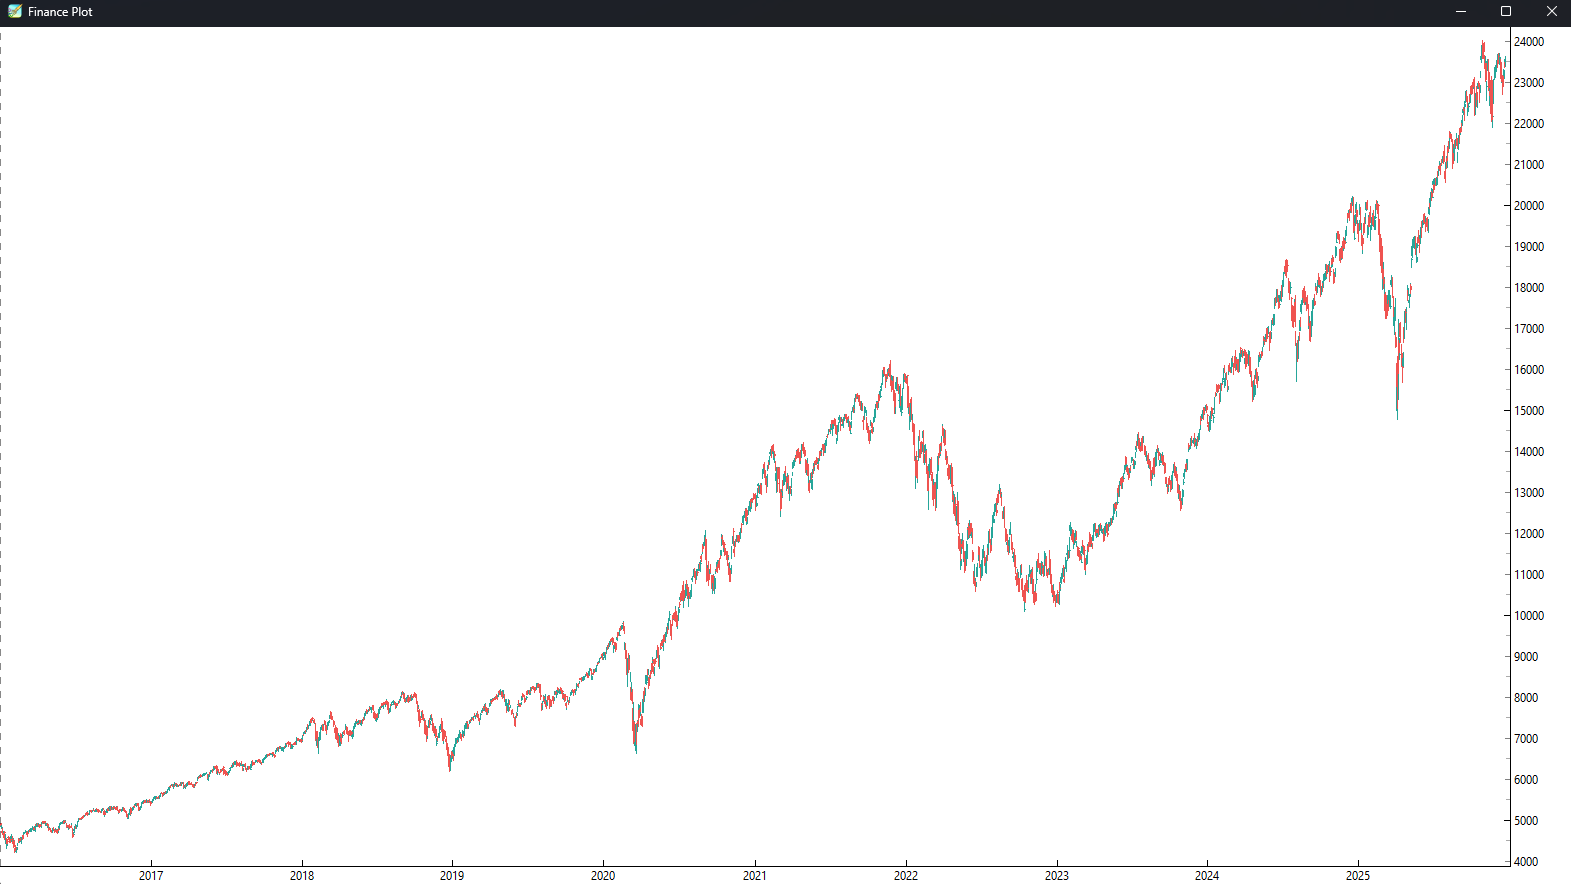

In [68]:
# Plot visible with finplot library, more interactive.
Image("NAS_D.png")

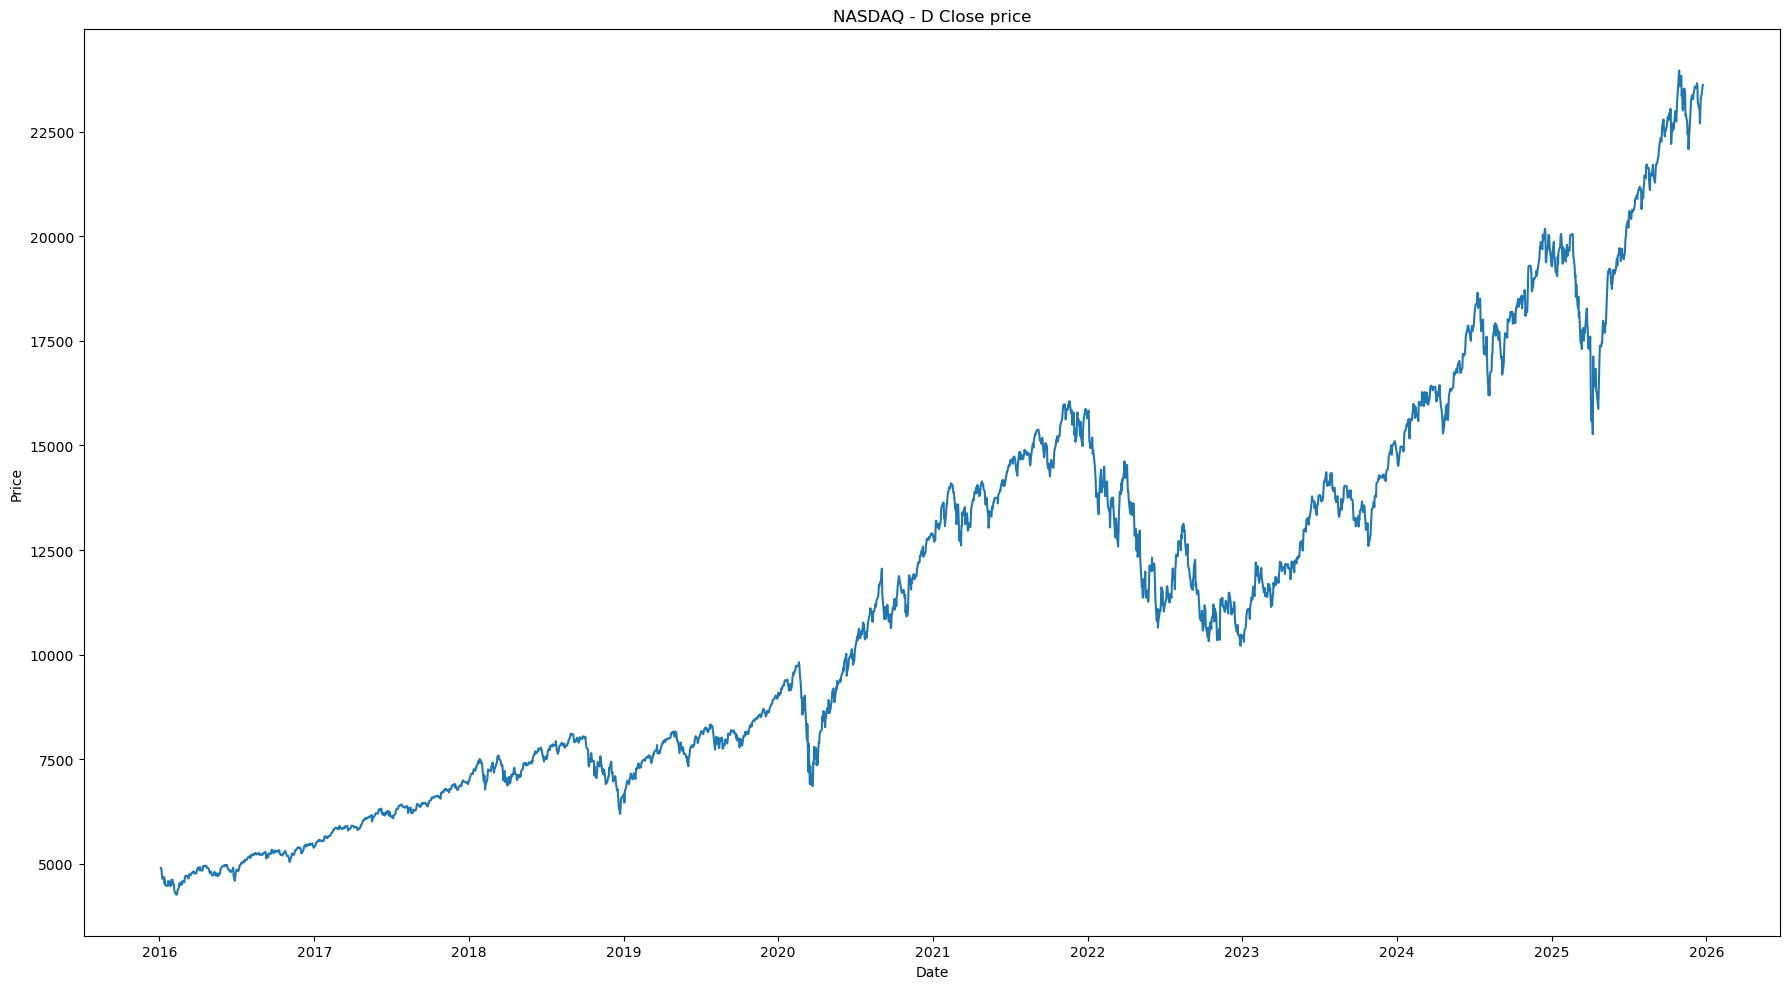

In [69]:
plt.figure(figsize = (18,10))
# plt.plot(df["Date"].iloc[-100:-1],df["Close"].iloc[-100:-1])
plt.plot(df["Date"],df["Close"])
plt.title("NASDAQ - D Close price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [70]:
# Calculating the daily log return, better for ML models, as it makes values more comparable across time and improves statistical stability.
df["return"] = np.log(df["Close"] / df["Close"].shift(1))
df.head()

,Date,Close,High,Low,Open,Volume,return
0,2016-01-04,4903.089844,4903.089844,4846.979980,4897.649902,2218420000,NaN
1,2016-01-05,4891.430176,4926.729980,4872.740234,4917.839844,1927380000,-0.002381
2,2016-01-06,4835.759766,4866.040039,4804.689941,4813.759766,2168620000,-0.011446
3,2016-01-07,4689.430176,4788.020020,4688.169922,4736.399902,2552590000,-0.030727
4,2016-01-08,4643.629883,4742.569824,4637.850098,4722.020020,2288750000,-0.009815


In [71]:
# Target value for the ML model
df["y"] = df["return"].shift(-1)
df.head()

,Date,Close,High,Low,Open,Volume,return,y
0,2016-01-04,4903.089844,4903.089844,4846.979980,4897.649902,2218420000,NaN,-0.002381
1,2016-01-05,4891.430176,4926.729980,4872.740234,4917.839844,1927380000,-0.002381,-0.011446
2,2016-01-06,4835.759766,4866.040039,4804.689941,4813.759766,2168620000,-0.011446,-0.030727
3,2016-01-07,4689.430176,4788.020020,4688.169922,4736.399902,2552590000,-0.030727,-0.009815
4,2016-01-08,4643.629883,4742.569824,4637.850098,4722.020020,2288750000,-0.009815,-0.001215


In [72]:
# Getting rid of the NaN first and last row.
df = df.copy()
df.dropna(inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume,return,y
1,2016-01-05,4891.430176,4926.729980,4872.740234,4917.839844,1927380000,-0.002381,-0.011446
2,2016-01-06,4835.759766,4866.040039,4804.689941,4813.759766,2168620000,-0.011446,-0.030727
3,2016-01-07,4689.430176,4788.020020,4688.169922,4736.399902,2552590000,-0.030727,-0.009815
4,2016-01-08,4643.629883,4742.569824,4637.850098,4722.020020,2288750000,-0.009815,-0.001215
5,2016-01-11,4637.990234,4683.020020,4573.779785,4673.439941,2391110000,-0.001215,0.010281


In [73]:
# Additional features, as the yesterdays return and the return a week ago.
df["return_1d_ago"] = df["return"].shift(1)
df["return_1w_ago"] = df["return"].shift(5)
df["return_1M_ago"] = df["return"].shift(20)
df.dropna(inplace= True)

In [74]:
df

,Date,Close,High,Low,Open,Volume,return,y,return_1d_ago,return_1w_ago,return_1M_ago
21,2016-02-03,4504.240234,4547.319824,4424.470215,4543.819824,2466190000,-0.002818,0.001180,-0.022638,-0.022024,-0.002381
22,2016-02-04,4509.560059,4545.520020,4463.990234,4492.479980,2200930000,0.001180,-0.033008,-0.002818,0.008582,-0.011446
23,2016-02-05,4363.140137,4493.189941,4350.370117,4491.479980,2489280000,-0.033008,-0.018363,0.001180,0.023524,-0.030727
24,2016-02-08,4283.750000,4301.529785,4212.810059,4288.020020,2702070000,-0.018363,-0.003505,-0.033008,0.001390,-0.009815
25,2016-02-09,4268.759766,4329.609863,4222.479980,4224.870117,2465790000,-0.003505,0.003468,-0.018363,-0.022638,-0.001215
...,...,...,...,...,...,...,...,...,...,...,...
2504,2025-12-17,22693.320312,23159.199219,22692.000000,23135.609375,8616140000,-0.018258,0.013700,0.002341,0.003289,-0.012194
2505,2025-12-18,23006.359375,23149.609375,22906.230469,23012.060547,7977920000,0.013700,0.013010,-0.018258,-0.002552,0.005840
2506,2025-12-19,23307.619141,23307.910156,23106.189453,23121.900391,12874560000,0.013010,0.005187,0.013700,-0.017042,-0.021782
2507,2025-12-22,23428.830078,23476.500000,23362.929688,23450.529297,7244910000,0.005187,0.005661,0.013010,-0.005957,0.008795


In [75]:
# Creating the ML model training datasets
split_date = "2023-01-01"
train = df[df["Date"] < split_date]
test = df[df["Date"] >= split_date]

x_train = train[["return","return_1d_ago","return_1w_ago","return_1M_ago"]]
y_train = train["y"]

x_test = test[["return","return_1d_ago","return_1w_ago","return_1M_ago"]]
y_test = test["y"]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1741, 4) (1741,)
(747, 4) (747,)


In [76]:
model = lgb.LGBMRegressor(random_state = 23)
model.fit(x_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1741, number of used features: 4
[LightGBM] [Info] Start training from score 0.000480


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [77]:
y_pred = model.predict(x_test)

In [78]:
# vidējās kļūdas noteikšana
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.009780931483469039


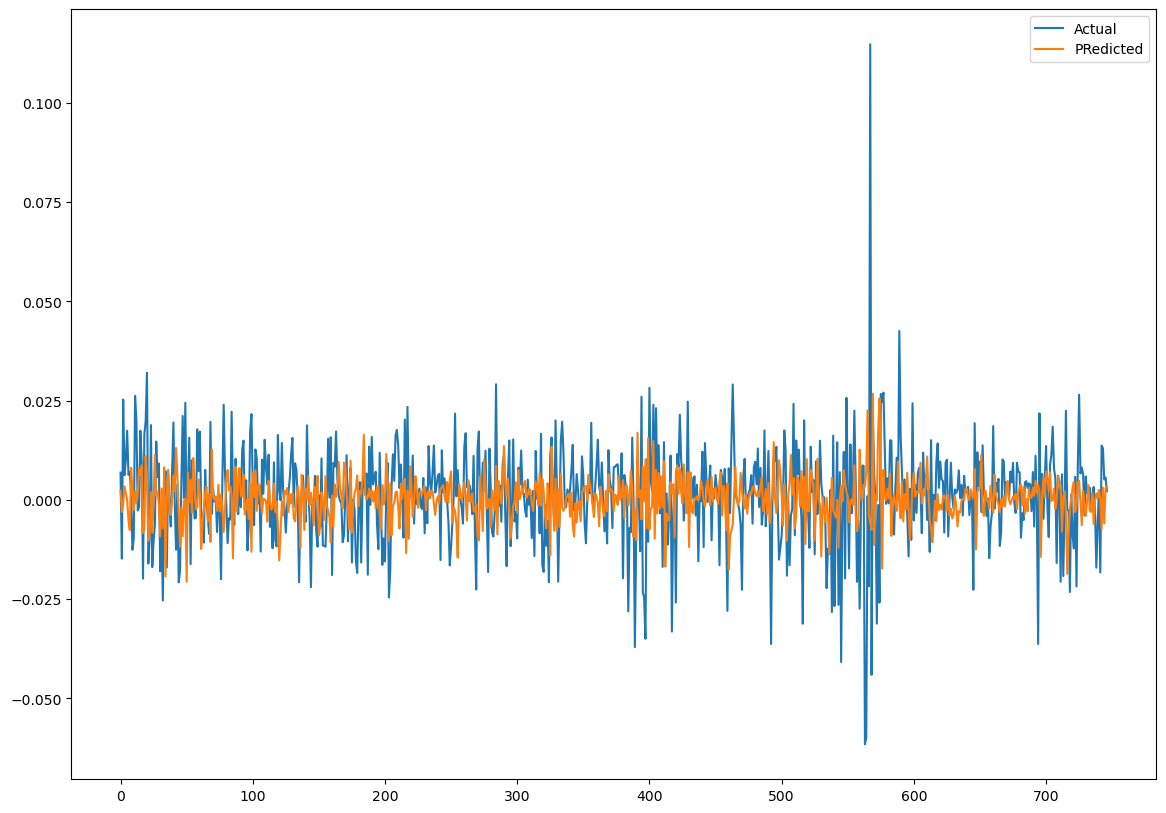

In [79]:
plt.figure(figsize = (14,10))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="PRedicted")
plt.legend()
plt.show()

In [80]:
# Future prediction creation
# Getting the start price and feature values for the monte carlo simulation
start_price = float(df["Close"].iloc[-1])
start_features = df[["return","return_1d_ago","return_1w_ago","return_1M_ago"]].iloc[-1]

start_price, start_features


(23561.83984375,
 return           0.005661
 return_1d_ago    0.005187
 return_1w_ago    0.002341
 return_1M_ago    0.026535
 Name: 2508, dtype: float64)

In [81]:
# Noise for the monte carlo simulation
residuals = (y_train - model.predict(x_train))
sigma = residuals.std()

sigma

0.009076970630896974

In [82]:
# Creating a single price simulation assuming the features ( daily, weekly, monthly returns ) are constant. 
prices = np.empty(253)
prices[0] = start_price

features = start_features.to_frame().T.copy()

for t in range(1,253):
    r_pred = model.predict(features)[0]
    r_sim = r_pred + np.random.normal(0,sigma)
    prices[t] = prices[t-1] * np.exp(r_sim)

prices[:5], prices[-5:]

(array([23561.83984375, 23777.74623296, 23851.69994575, 23727.85141234,
        23726.69463896]),
 array([65077.69099163, 65495.23730258, 64817.98439655, 64220.87693471,
        65715.74954922]))

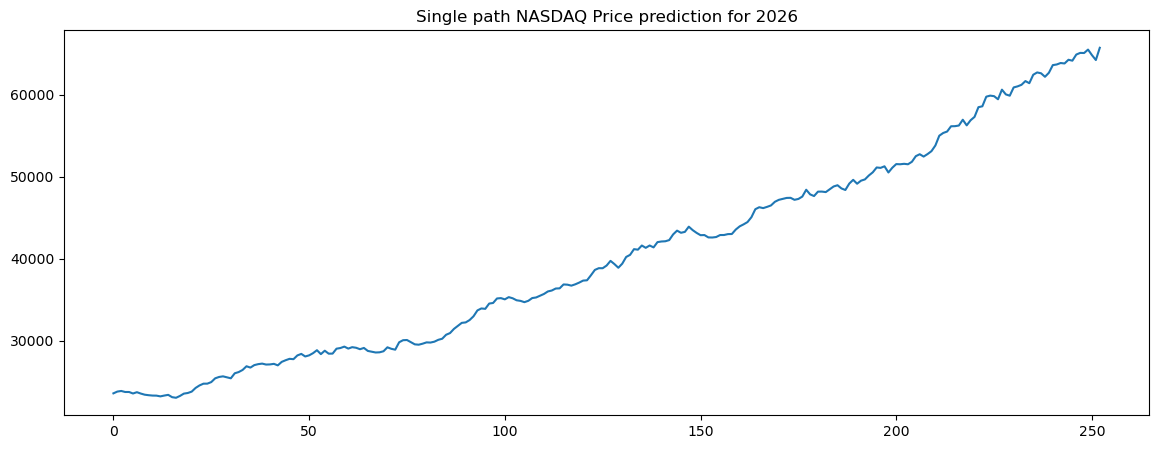

In [83]:
plt.figure(figsize = (14,5))
plt.plot(prices)
plt.title("Single path NASDAQ Price prediction for 2026")
plt.show()

In [84]:
# Creating multiple paths
# 100 simulations for 252 trading days
paths = np.empty((100, 253))
paths[:,0] = start_price

for s in range(100):
    for t in range(1,253):
        r_pred = model.predict(features)[0]
        r_sim = r_pred + np.random.normal(0, sigma)
        paths[s,t] = paths[s,t-1] * np.exp(r_sim)

paths.shape

(100, 253)

In [85]:
# Calculate the percentiles for the Monte Carlo simulation to summarize the paths, obtain a median forecast, and add an uncertainty range.
p10 = np.percentile(paths,10,axis=0)
p50 = np.percentile(paths,50,axis=0)
p90 = np.percentile(paths,90,axis=0)

p10.shape, p50.shape, p90.shape

((253,), (253,), (253,))

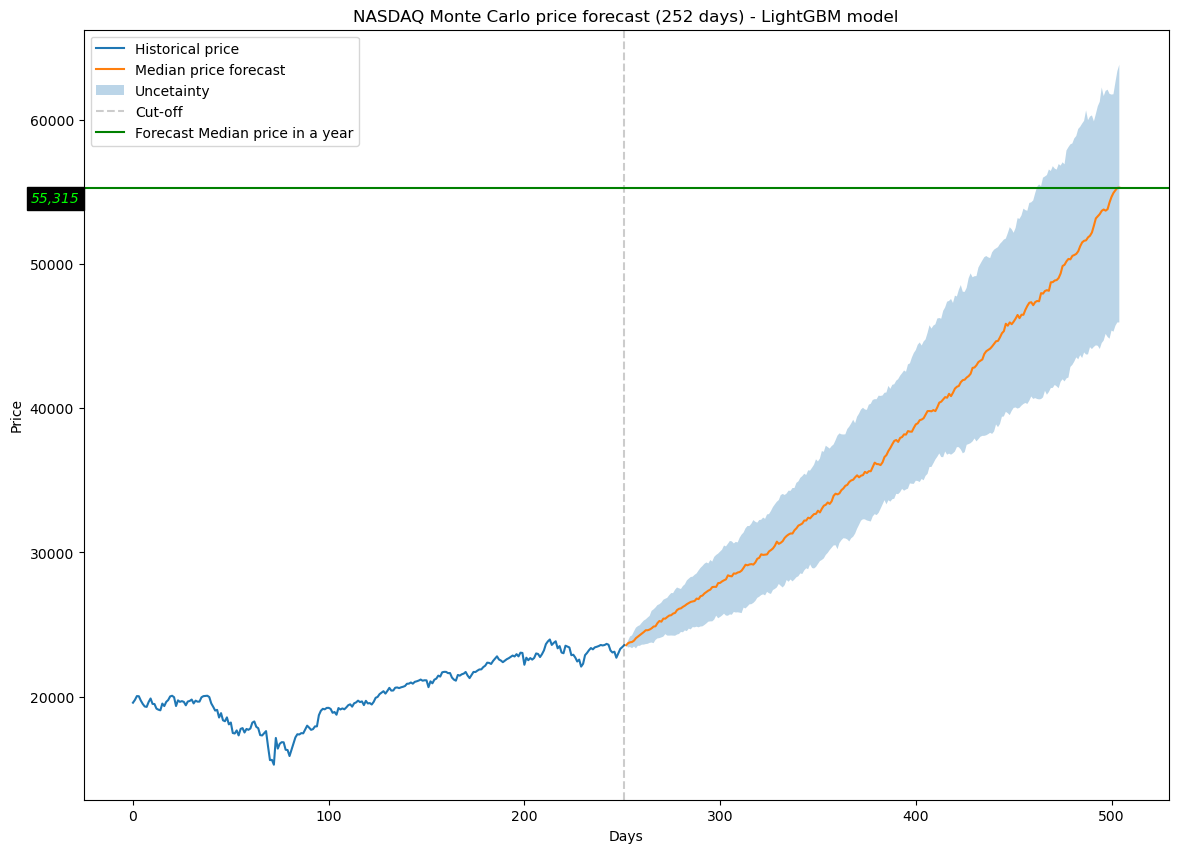

In [86]:
# Plotting the simulation results and the final price at the end of the forecasted year
historical = df["Close"].iloc[-252:].values

x_hist = np.arange(len(historical))
x_forecast = np.arange(len(historical), len(historical) + len(p50))

plt.figure(figsize = (14,10))
plt.plot(x_hist, historical, label = "Historical price")
plt.plot(x_forecast, p50, label = "Median price forecast")
plt.fill_between(x_forecast, p10, p90, alpha = 0.3, label = "Uncetainty")
plt.axvline(x_hist[-1], color = "k", label = "Cut-off", linestyle = "--", alpha = 0.2)
plt.axhline(p50[-1], color = "green", label = "Forecast Median price in a year")

plt.text(-52, p50[-6], f"{p50[-1]:,.0f}", fontstyle = "italic", color = "lime", bbox=dict(boxstyle = "square",facecolor = "k",edgecolor = "k"))

plt.xlabel("Days")
plt.ylabel("Price")
plt.title("NASDAQ Monte Carlo price forecast (252 days) - LightGBM model")
plt.legend()
plt.show()